# Classification with FACET

***

**Robust and impactful Data Science with FACET**

FACET enables us to perform several critical steps in best practice Data Science work flow easily, efficiently and reproducibly:

1. Create a robust pipeline for learner selection using LearnerRanker and cross-validation.

2. Enhance our model inspection to understand drivers of predictions using local explanations of features via [SHAP values](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) by applying a novel methodology that decomposes SHAP values into measures of synergy, redundancy, and independence between each pair of features.

3. Quickly apply historical simulation to gain key insights into feature values that minimize or maximize the predicted outcome.

***

**Context**

Prediabetes is a treatable condition that leads to many health complications and eventually type 2 diabetes. Identification of  individuals at risk of prediabetes can improve early intervention and provide insights into those interventions that work best.
Using a cohort of healthy (*n*=2847) and prediabetic (*n*=1509) patients derived 
from the [NHANES 2013-14 U.S. cross-sectional survey](https://wwwn.cdc.gov/nchs/nhanes/Search/DataPage.aspx?Component=Examination&CycleBeginYear=2013) we aim to create a classifier for prediabetes. For further details on data sources, definitions and the study cohort please see the Appendix ([Data source and study cohort](#Data-source-and-study-cohort)).

Utilizing FACET, we will do the following:

1. create a pipeline to find identify a well-performing classifier.
2. perform model inspection and simulation to gain understanding and insight into key factors predictive of prediabetes.

***

**Tutorial outline**

1. [Required imports](#Required-imports)
2. [Preprocessing and initial feature selection](#Preprocessing-and-initial-feature-selection)
3. [Selecting a learner using FACET ranker](#Selecting-a-learner-using-FACET-ranker)
4. [Using the FACET inspector for model inspection](#Using-the-FACET-inspector-for-model-inspection)
5. [FACET univariate simulator: the impact of waist to height ratio](#FACET-univariate-simulator:-the-impact-of-waist-to-height-ratio)
6. [Summary](#Summary)
7. [What can you do next?](#What-can-you-do-next?)
8. [Appendix](#Appendix)

In [28]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx


def _set_paths() -> None:
    # set the correct path when launched from within PyCharm

    module_paths = ["pytools", "facet", "sklearndf"]

    import sys
    import os

    if "cwd" not in globals():
        # noinspection PyGlobalUndefined
        global cwd
        cwd = os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir)
        os.chdir(cwd)
    print(f"working dir is '{os.getcwd()}'")
    for module_path in module_paths:
        if module_path not in sys.path:
            sys.path.insert(0, os.path.abspath(f"{cwd}/{os.pardir}/{module_path}/src"))
        print(f"added `{sys.path[0]}` to python paths")


def _ignore_warnings():
    # ignore irrelevant warnings that would affect the output of this tutorial notebook

    # ignore a useless LGBM warning
    import warnings

    warnings.filterwarnings("ignore", category=UserWarning, message=r".*Xcode_8\.3\.3")


_set_paths()
_ignore_warnings()

del _set_paths, _ignore_warnings

working dir is 'C:\Projects\facet\facet'
added `C:\Projects\facet\pytools\src` to python paths
added `C:\Projects\facet\facet\src` to python paths
added `C:\Projects\facet\sklearndf\src` to python paths


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [29]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx

import warnings

warnings.filterwarnings("ignore")


def _configure_matplotlib():
    # set global options for matplotlib

    import matplotlib

    matplotlib.rcParams["figure.figsize"] = (16.0, 8.0)
    matplotlib.rcParams["figure.dpi"] = 72


_configure_matplotlib()

del _configure_matplotlib

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# Required imports

In order to run this notebook, we will import not only the FACET package, but also other packages useful to solve this task. Overall, we can break down the imports into three categories: 

1. Common packages (pandas, matplotlib, etc.)
2. Required FACET classes (inspection, selection, validation, simulation, etc.)
3. Other BCG Gamma packages which simplify pipelining (sklearndf, see on [GitHub](https://github.com/orgs/BCG-Gamma/sklearndf/)) and support visualization (pytools, see on [GitHub](https://github.com/BCG-Gamma/pytools)) when using FACET

**Common package imports**

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from tableone import TableOne
from sklearn.compose import make_column_selector
from sklearn.model_selection import RepeatedKFold

**Gamma FACET imports**

In [31]:
from facet.data import Sample
from facet.inspection import LearnerInspector
from facet.selection import LearnerRanker, LearnerGrid
from facet.validation import BootstrapCV
from facet.simulation.partition import ContinuousRangePartitioner
from facet.simulation import UnivariateProbabilitySimulator
from facet.simulation.viz import SimulationDrawer
from facet.crossfit import LearnerCrossfit

**sklearndf imports**

Instead of using the "regular" scikit-learn package, we are going to use sklearndf (see on [GitHub](https://github.com/orgs/BCG-Gamma/sklearndf/)). sklearndf is an open source library designed to address a common issue with scikit-learn: the outputs of transformers are numpy arrays, even when the input is a data frame. However, to inspect a model it is essential to keep track of the feature names. sklearndf retains all the functionality available through scikit-learn plus the feature traceability and usability associated with Pandas DataFrames. Additionally, the names of all your favourite scikit-learn functions are the same except for `DF` on the end. For example, the standard scikit-learn import:

`from sklearn.pipeline import Pipeline`

becomes:

`from sklearndf.pipeline import PipelineDF`

In [32]:
from sklearndf.pipeline import PipelineDF, ClassifierPipelineDF
from sklearndf.classification import RandomForestClassifierDF
from sklearndf.classification.extra import LGBMClassifierDF
from sklearndf.transformation import (
    ColumnTransformerDF,
    OneHotEncoderDF,
    SimpleImputerDF,
)
from sklearndf.transformation.extra import BorutaDF

**pytools imports**

pytools (see on [GitHub](https://github.com/BCG-Gamma/pytools)) is an open source library containing general machine learning and visualisation utilities, some of which are useful for visualising the advanced model inspection capabilities of FACET.

In [33]:
from pytools.viz.dendrogram import DendrogramDrawer, LinkageTree
from pytools.viz.matrix import MatrixDrawer

# Preprocessing and initial feature selection

First we need to load our prediabetes data and create a simple preprocessing pipeline. For those interested some initial EDA can be found in the Appendix ([Exploratory Data Analysis](#Exploratory-Data-Analysis-(EDA))).

In [34]:
# load the prepared dataframe
prediab_df = pd.read_csv("sphinx/source/tutorial/pre_diab_nhanes.csv")

# create a couple of new interesting features
prediab_df["SBP_to_DBP"] = prediab_df["Average_SBP"] / prediab_df["Average_DBP"]
prediab_df["Waist_to_hgt"] = (
    prediab_df["Waist_Circumference"] / prediab_df["Standing_Height"]
)

# make clear based on dtypes these two features are categorical
prediab_df["General_health"] = prediab_df["General_health"].astype("object")
prediab_df["Healthy_diet"] = prediab_df["Healthy_diet"].astype("object")

# have a look
prediab_df.head()

,Age,Gender,Waist_Circumference,Weight,Standing_Height,BMI,Average_SBP,Average_DBP,HDL_Cholesterol,Total_Cholesterol,...,Osmolality,Sodium,Potassium,Gamma_glutamyl_transferase,Calcium,Alanine_aminotransferase,Aspartate_aminotransferase,Pre_diab,SBP_to_DBP,Waist_to_hgt
0,73.0,2.0,NaN,52.0,162.4,19.7,137.333333,86.666667,85.0,201.0,...,290.0,142.0,4.1,31.0,10.0,28.0,36.0,1,1.584615,NaN
1,56.0,1.0,123.1,105.0,158.7,41.7,157.333333,82.000000,38.0,226.0,...,287.0,143.0,3.3,22.0,9.3,16.0,24.0,0,1.918699,0.775677
2,61.0,2.0,110.8,93.4,161.8,35.7,122.666667,80.666667,58.0,168.0,...,281.0,140.0,3.9,17.0,9.9,21.0,20.0,1,1.520661,0.684796
3,56.0,2.0,85.5,61.8,152.8,26.5,122.000000,72.666667,59.0,278.0,...,277.0,139.0,4.0,21.0,9.5,24.0,23.0,0,1.678899,0.559555
4,65.0,1.0,93.7,65.3,172.4,22.0,141.333333,77.333333,79.0,173.0,...,281.0,140.0,4.8,24.0,9.5,20.0,29.0,0,1.827586,0.543503


In [35]:
# to ensure a quick run we will use a random sample of 1000 observations
prediab_df = prediab_df.sample(n=1000, random_state=42)

For easier data management we will create a sample object using FACET's `Sample` class, which allows us to: 

- Quickly access the target vs. features
- Pass our data into sklearndf pipelines
- Pass information to other FACET functions

In [36]:
# create a FACET sample object
prediab = Sample(
    observations=prediab_df,
    feature_names=prediab_df.drop(columns=["Pre_diab"]).columns,
    target_name="Pre_diab",
)

Next we create a minimum preprocessing pipeline which based on our initial EDA ([Exploratory Data Analysis](#Exploratory-Data-Analysis-(EDA))) needs to address the following:

1. Simple imputation for missing values in both continuous and categorical features
2. One-hot encoding for categorical features

We will use the sklearndf wrappers for scikit-learn functions such as `SimpleImputerDF` in place of `SimpleImputer`, `OneHotEncoderDF` in place of `OneHotEncoder`, and so on.

In [37]:
# for categorical features we will use the mode as the imputation value and also one-hot encode
preprocessing_categorical = PipelineDF(
    steps=[
        ("imputer", SimpleImputerDF(strategy="most_frequent", fill_value="<na>")),
        ("one-hot", OneHotEncoderDF(sparse=False, handle_unknown="ignore")),
    ]
)

# for numeric features we will impute using the median
preprocessing_numerical = SimpleImputerDF(strategy="median")

# put the pipeline together
preprocessing_features = ColumnTransformerDF(
    transformers=[
        (
            "categorical",
            preprocessing_categorical,
            make_column_selector(dtype_include=object),
        ),
        (
            "numerical",
            preprocessing_numerical,
            make_column_selector(dtype_include=np.number),
        ),
    ]
)

Next, we perform some initial feature selection using Boruta, a recent approach shown to have quite good performance. The Boruta algorithm removes features that are no more predictive than random noise. If you are interested further, please see this  [article](https://www.jstatsoft.org/article/view/v036i11).

The `BorutaDF` transformer in our sklearndf package provides easy access to this powerful method. The approach relies on a tree-based learner, usually a random forest. For settings, a `max_depth` of between 3 and 7 is typically recommended, and here we rely on the default setting of 5. However, as this depends on the number of features and the complexity of interactions one could also explore the sensitivity of feature selection to this parameter. The number of trees is automatically managed by the Boruta feature selector argument `n_estimators="auto"`.

We also use parallelization for the random forest using `n_jobs` to accelerate the Boruta iterations.

In [38]:
# create the pipeline for Boruta
boruta_feature_selection = PipelineDF(
    steps=[
        ("preprocessing", preprocessing_features),
        (
            "boruta",
            BorutaDF(
                estimator=RandomForestClassifierDF(
                    max_depth=5, n_jobs=-3, random_state=42
                ),
                n_estimators="auto",
                random_state=42,
                verbose=False,
            ),
        ),
    ]
)

# run feature selection using Boruta and report those selected
boruta_feature_selection.fit(X=prediab.features, y=prediab.target)
selected = boruta_feature_selection.feature_names_original_.unique()
selected

array(['Age', 'Waist_Circumference', 'BMI', 'Average_SBP', 'RBC_count',
       'Hematocrit', 'Uric_acid', 'Gamma_glutamyl_transferase',
       'SBP_to_DBP', 'Waist_to_hgt'], dtype=object)

Boruta identified 10 features (out of a potential 47) that we will retain in our FACET sample object for classification. Note that this feature selection process could be included in a general preprocessing pipeline, however due to the computation involved, we have utilized Boruta here as an initial one-off processing step to narrow down the features for our classifier development.

In [39]:
# update FACET sample object to only those features Boruta identified as useful
prediab_initial_features = prediab.keep(selected)

# Selecting a learner using FACET ranker

FACET implements several additional useful wrappers which further simplify comparing and tuning a larger number of models and configurations: 

- `LearnerGrid`: allows you to pass a learner pipeline (i.e., classifier + any preprocessing) and a set of hyperparameters
- `LearnerRanker`: multiple LearnerGrids can be passed into this class as a list - this allows tuning hyperparameters both across different types of learners in a single step and ranks the resulting models accordingly

The following learners and hyperparameter ranges will be assessed using 10 repeated 5-fold cross-validation:


1. **Random forest**: with hyperparameters
    - max_leaf_nodes: [5, 10, 20]
    - n_estimators: [50, 100, 200]  
  
  
2. **Light gradient boosting**: with hyperparameters
    - max_depth: [5, 10]
    - num_leaves: [20]
    - learning_rate: [0.2, 0.1]
    - subsample: [0.7]
    - feature_fraction: [0.8]

Note if you want to see a list of hyperparameters you can use `classifier_name().get_params().keys()` where `classifier_name` could be for example `RandomForestClassifierDF` and if you want to see the default values, just use `classifier_name().get_params()`.

Finally, for this exercise we will use AUC as the performance metric for scoring and ranking our classifiers (the default is accuracy). Note that ranking uses the average performance minus two times the standard deviation, so that we consider both the average performance and variability when selecting a classifier.

First, we specify the classifiers we want to train using `ClassifierPipelineDF` from sklearndf. Note here we also include the feature preprocessing steps we created earlier.

In [40]:
# random forest learner
rforest_clf = ClassifierPipelineDF(
    preprocessing=preprocessing_features,
    classifier=RandomForestClassifierDF(random_state=42),
)

# light gradient boosting learner
lgbm_clf = ClassifierPipelineDF(
    preprocessing=preprocessing_features,
    classifier=LGBMClassifierDF(random_state=42)
)

Then we create a list of learner grids where each learner grid is created using `LearnerGrid` and allows us to associate a `ClassifierPipelineDF` with a specified set of hyperparameter via the `learner_parameters` argument. Note this structure allows us to easily include additional classifiers and hyperparameters.

In [41]:
classifier_grid = [
    LearnerGrid(
        pipeline=rforest_clf,
        learner_parameters={"max_depth": [4, 8, 16, 32], "n_estimators": [200, 500]},
    ),
    LearnerGrid(
        pipeline=lgbm_clf,
        learner_parameters={
            "max_depth": [5, 10],
            "num_leaves": [20],
            "learning_rate": [0.2, 0.1],
            "subsample": [0.7],
            "feature_fraction": [0.8],
        },
    ),
]

We now fit the grid defined above using the `LeanerRanker`, which will run a gridsearch (or random search if defined) using 10 repeated 5-fold cross-validation on our selected set of features from Boruta.

In [42]:
clf_ranker = LearnerRanker(
    grids=classifier_grid,
    cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),
    n_jobs=-3,
    scoring="roc_auc",
).fit(prediab_initial_features)

We can see how each model scored using the `summary_report()` method of the `LearnerRanker`.

In [43]:
# let's look at performance for the top 5 ranked classifiers
print(clf_ranker.summary_report(5))

Rank  1: RandomForestClassifierDF, ranking_score=    0.655, scores_mean=    0.722, scores_std=   0.0334, parameters={classifier__max_depth=4,classifier__n_estimators=500}

Rank  2: RandomForestClassifierDF, ranking_score=    0.655, scores_mean=    0.721, scores_std=   0.0331, parameters={classifier__max_depth=4,classifier__n_estimators=200}

Rank  3: RandomForestClassifierDF, ranking_score=    0.654, scores_mean=    0.718, scores_std=   0.0318, parameters={classifier__max_depth=8,classifier__n_estimators=500}

Rank  4: RandomForestClassifierDF, ranking_score=    0.654, scores_mean=    0.717, scores_std=   0.0314, parameters={classifier__max_depth=8,classifier__n_estimators=200}

Rank  5:         LGBMClassifierDF, ranking_score=    0.653, scores_mean=    0.708, scores_std=   0.0276, parameters={classifier__max_depth=5,classifier__num_leaves=20,classifier__learning_rate=0.1,classifier__subsample=0.7,classifier__feature_fraction=0.8}



We can see based on our learner ranker, we have selected a Random Forest algorithm that achieved a mean ROC AUC of 0.72 with a SD of 0.03.

# Using the FACET inspector for model inspection

The [SHAP approach](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) has become the standard method for model inspection. SHAP values are used to explain the additive contribution of each feature to the prediction for a given observation. SHAP values are computed for every feature and observation.

The FACET `LearnerInspector` computes SHAP values for each crossfit (i.e., a CV fold or bootstrap resample) using the best model identified by the `LearnerRanker`. The FACET `LearnerInspector` then provides advanced model inspection through new SHAP-based summary metrics for understanding feature redundancy and synergy. Redundancy and synergy are calculated using the new algorithm FACET implements for using SHAP values to understand model predictions.

The definitions are as follows:

- **Redundancy** represents how much information is shared between two features contributions to the model predictions. For example, given features X and Y as coordinates on a chess board, the colour of a square can only be predicted when considering X and Y in combination. Redundancy is expressed as a percentage ranging from 0% (full uniqueness) to 100% (full redundancy).


- **Synergy** represents how much the combined information of two features contributes to the model predictions. For example, temperature and pressure in a pressure cooker are redundant features for predicting cooking time since pressure will rise relative to the temperature, and vice versa. Therefore, knowing just one of either temperature or pressure will likely enable the same predictive accuracy. Synergy is expressed as a percentage ranging from 0% (full autonomy) to 100% (full synergy).

Both cases can apply at the same time, i.e. a pair of features can use some information synergistically while using other information redundantly.

To analyse redundancy for all possible feature parings, the approach is:

1.	Calculate the feature redundancy matrix using SHAP value decomposition - this gives us pairwise redundancy between features, in the range of 0.0 (fully unique contributions) and 1.0 (fully redundant contributions)
2.	Transform the feature redundancy matrix into a feature distance matrix, where distance is expressed as (1.0 - redundancy)
3.	Perform hierarchical, single-linkage clustering on the distance matrix, thus identifying groups of low-distance, redundant features which activate “in tandem” to predict the outcome

The same approach can be used to analyse synergy.

The inspector can calculate all of this with a single method call, but also offers methods to access the intermediate results of each step. A lightweight visualization framework is available to render the results in different styles.

SHAP values from the `LearnerInspector` can also be used with the SHAP package plotting functions for sample and observation level SHAP visualizations, such as SHAP distribution plots, dependency plots, force plots and waterfall plots.

In [44]:
# run inspector
clf_inspector = LearnerInspector(
    n_jobs=-3,
    verbose=False,
).fit(crossfit=clf_ranker.best_model_crossfit_)

In [45]:
# obtain FACET feature importance, as well as synergy and redundancy matrices
f_importance = clf_inspector.feature_importance()
redundancy_matrix = clf_inspector.feature_redundancy_matrix()
synergy_matrix = clf_inspector.feature_synergy_matrix()
dd_redundancy = clf_inspector.feature_redundancy_linkage()

# also let's get some info for standard SHAP plots
shap_values = clf_inspector.shap_values().to_numpy()
X_train = rforest_clf.preprocessing.fit_transform(X=prediab_initial_features.features)
X_train = X_train.reset_index()[prediab_initial_features.features.columns]

## Feature importance

Feature importance has many ways of being measured. Here we utilize the FACET implementation based on the `LearnerInspector`. Each feature is ranked according to the mean SHAP value for that feature. This plot is paired with a standard SHAP distribution plot for features to see if there is any directional tendency for the associations.

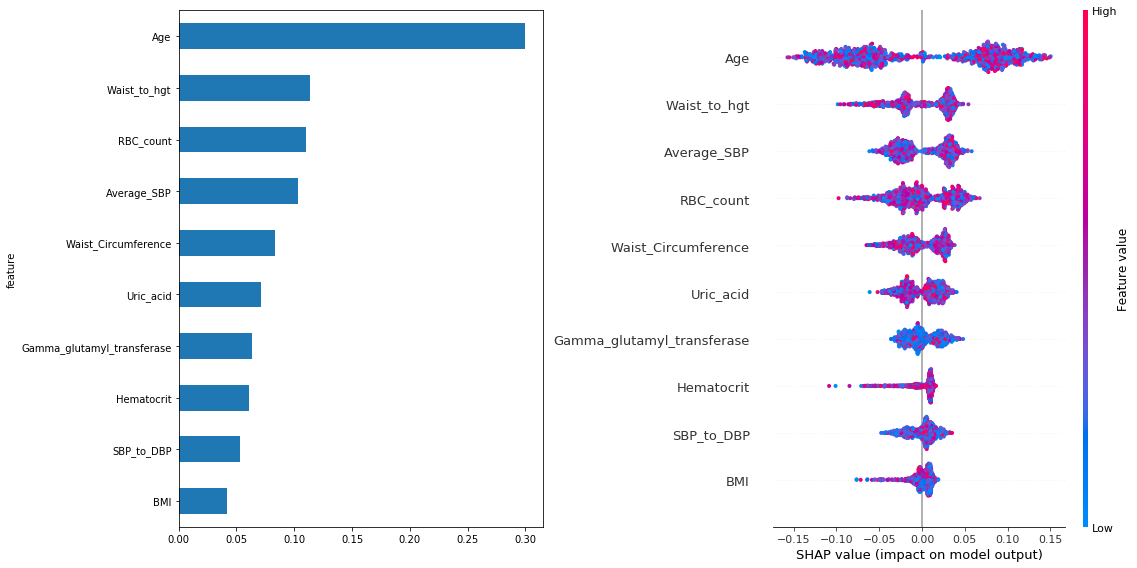

In [46]:
# FACET feature importance
plt.subplot(1, 2, 1)
f_importance.sort_values().plot.barh()

# standard SHAP summary plot using the shap package
plt.subplot(1, 2, 2)
shap.summary_plot(shap_values, X_train, show=False, plot_size=(16.0, 8.0))
plt.tight_layout()

Based on the feature importance's we can see the top five features are age, waist to height ratio, RBC count, average systolic blood pressure and waist circumference. Inspection of the SHAP value distributions does not provide any indication of a general direction of association for any features.

## Synergy and redundancy

Synergy and redundancy are part of the key extensions FACET makes to using SHAP values to understand model predictions.

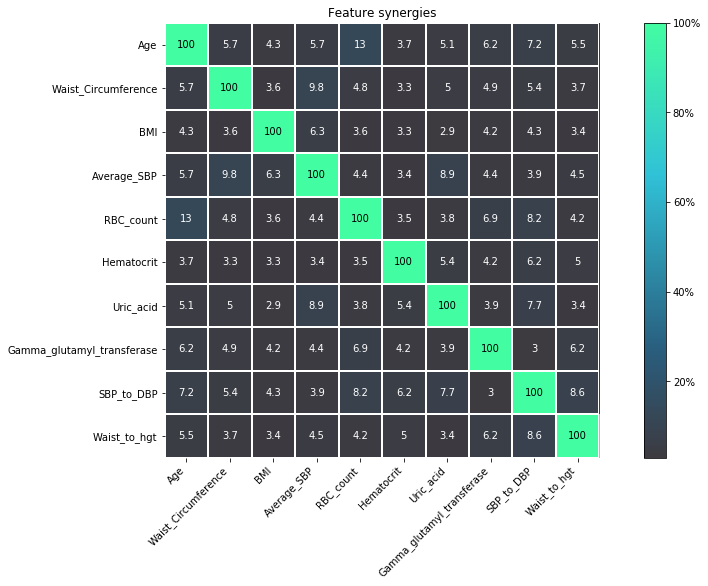

In [47]:
# synergy heatmap
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Feature synergies")

*Synergy represents the degree to which one feature combines with another to generate a prediction.* In the above heatmap we can see the off-diagonal values never exceed 15%. This would suggest that no two features have a strong degree of synergy.

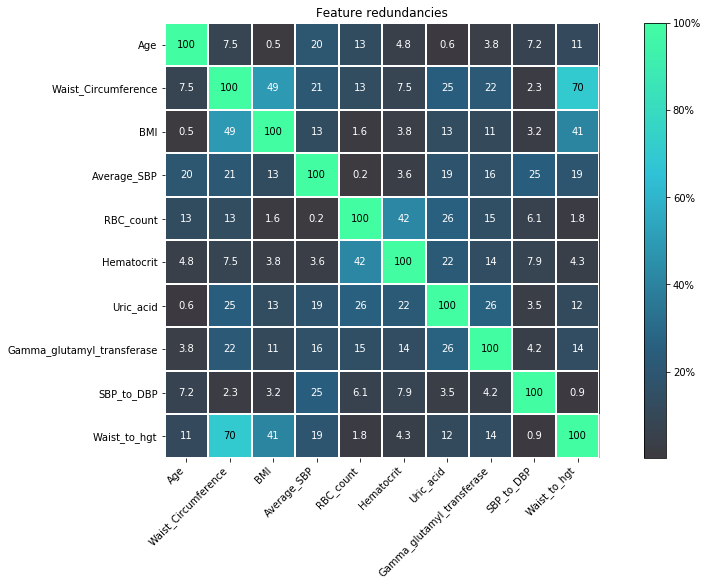

In [48]:
# redundancy heatmap
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Feature redundancies")

*Redundancy represents the shared information between two features.* In the above heatmap we can see a values of 49% and higher for (`Waist_circumference` and `Waist_to_hgt`), (`Waist_circumference` and `BMI`) and (`BMI` and `Waist_to_hgt`). Another way to look at redundancy is using a dendrogram.

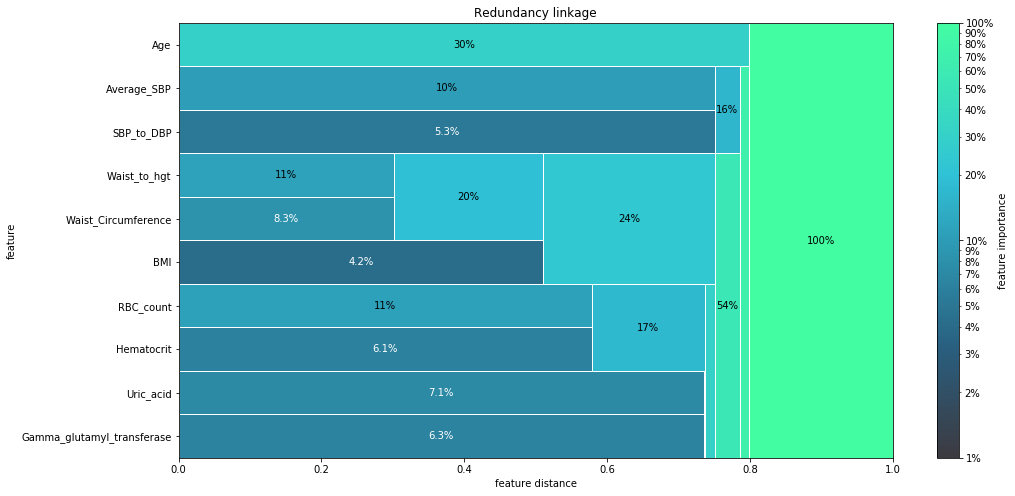

In [49]:
# redundancy dendrogram
DendrogramDrawer().draw(title="Redundancy linkage", data=dd_redundancy)

The dendrogram represents the extent of clustering among the features.

To obtain the hierarchical clustering, we calculate a linkage tree and plug it into a dendrogram drawer. This makes it easy to visually single out features that are both important and mutually redundant.

Taking the `Waist_circumference` and `Waist_to_hgt` features which have the highest redundancy, we can see these features cluster together earliest in the dendrogram. Ideally, we want to see features only start to cluster as close to the right-hand side of the dendrogram as possible. This implies all features in the model are contributing uniquely to our predictions.

**What might we infer from the above information?**

1. BMI, waist circumference and waist to height ratio form a small cluster of redundant features. This seems reasonable:
    * waist circumference is included in the calculation of waist to height ratio
    * we might expect BMI to capture similar information about excess body mass as higher waist circumference and waist to height ratio
2. We saw little synergy between features. We might have expected apriori to find some interesting synergies between diet, exercise, sleep and body composition. Of course, the model needs to identify these relationships from them to be reflected in the synergy metric(s).

**What action(s) might we take?**

1. Given the redundancy that appears between BMI, waist circumference and waist to height ratio, we could look to eliminate one or two of these features from the model.

For convenience when working in a non-notebook environment, all of the `Drawer`s provided by the [pytools](https://github.com/BCG-Gamma/pytools) package also support a `style='text'` flag.

In [50]:
DendrogramDrawer(style="text").draw(title="Redundancy linkage", data=dd_redundancy)

****************************** Redundancy linkage ******************************
                                                                                
Age             30% -----------------------------------------------\            
Average_SBP     10% ---------------------------------------------\_|            
SBP_to_DBP       5% ---------------------------------------------/ |            
Waist_to_hgt    11% ------------------\___________                 |            
Waist_Circumfer  8% ------------------/           \--------------\ |___________ 
BMI              4% ------------------------------/              | /            
RBC_count       11% ----------------------------------\_________ |-/            
Hematocrit       6% ----------------------------------/         \/              
Uric_acid        7% --------------------------------------------/               
Gamma_glutamyl_  6% --------------------------------------------/               


## Removing redundant features

Recall the redundancy dendrogram above where we saw a clear cluster of features with redundancy; `Waist_to_hgt`, `BMI`, and `Waist_Circumference`.

- assess if the features of the model are unique, i.e. not redundant with other features
- decide which features to discard, combine, or modify to increase the uniqueness of important features in the model

Before we proceed to looking at SHAP values for individual predictions and perform a univariate simulation, let's eliminate two partially redundant features - we will choose to keep `Waist_to_hgt` ratio and drop `BMI` and `Waist_Circumference`. 

In [51]:
# drop redundant features from our FACET sample object
prediab_no_redundant_feat = prediab_initial_features.drop(
    ["BMI", "Waist_Circumference"]
)

In [52]:
# re-run ranker without redundant features
clf_ranker = LearnerRanker(
    grids=classifier_grid,
    cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),
    n_jobs=-3,
    scoring="roc_auc",
).fit(prediab_no_redundant_feat)

# run inspector
inspector_no_redun = LearnerInspector(
    n_jobs=-3,
    verbose=False,
).fit(crossfit=clf_ranker.best_model_crossfit_)

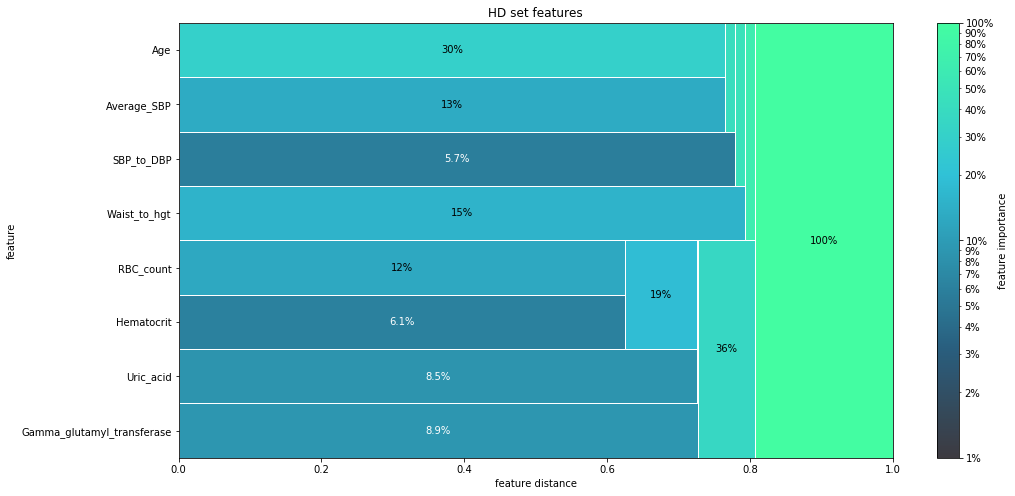

In [53]:
# redundancy dendrogram
dd_redundancy = inspector_no_redun.feature_redundancy_linkage()
DendrogramDrawer().draw(title="HD set features", data=dd_redundancy)

Now with the removal of `BMI` and `Waist_Circumference` we can see the feature clustering starts much further to the right.

We can also check the best ranked model after removing redundant features.

In [54]:
clf_ranker.best_model_

ClassifierPipelineDF(classifier=RandomForestClassifierDF(bootstrap=True,
                                                         ccp_alpha=0.0,
                                                         criterion='gini',
                                                         max_depth=4,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         n_estimators=2

# FACET univariate simulator: the impact of waist to height ratio

Another advantage of FACET is the ability to quickly instigate and run univariate simulation.
Simulation enables us to gain insight into what value(s) of this ratio might minimize the likelihood of prediabetes.

As the basis for the simulation, we divide the feature into relevant partitions: 

- We use FACET's `ContinuousRangePartitioner` to split the range of observed values of waist to height ratio into intervals of equal size. Each partition is represented by the central value of that partition. 
- For each partition, the simulator creates an artificial copy of the original sample assuming the variable to be simulated has the same value across all observations - which is the value representing the partition. Using the best `LearnerCrossfit` acquired from the ranker, the simulator now re-predicts all targets using the models trained for all folds and determines the average value of the target variable resulting from this.
- The FACET `SimulationDrawer` allows us to visualise the result; both in a matplotlib and a plain-text style

Finally, because FACET can use bootstrap cross validation, we can create a crossfit from our previous `LearnerRanker` best model to perform the simulation so we can quantify the uncertainty by using bootstrap confidence intervals.

In [55]:
# create a bootstrap CV crossfit for simulation using best model
boot_crossfit = LearnerCrossfit(
    pipeline=clf_ranker.best_model_.native_estimator,
    cv=BootstrapCV(n_splits=250, random_state=42),
    n_jobs=-3,
    verbose=2,
).fit(sample=prediab_no_redundant_feat)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  29 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-3)]: Done 150 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-3)]: Done 250 out of 250 | elapsed:   45.1s finished


In [56]:
# set-up and run a simulation
sim_feature = "Waist_to_hgt"
waist_to_hgt_simulator = UnivariateProbabilitySimulator(
    crossfit=boot_crossfit, n_jobs=-1
)
waist_to_hgt_partitions = ContinuousRangePartitioner()
waist_to_hgt_simulation = waist_to_hgt_simulator.simulate_feature(
    name=sim_feature, partitioner=waist_to_hgt_partitions
)

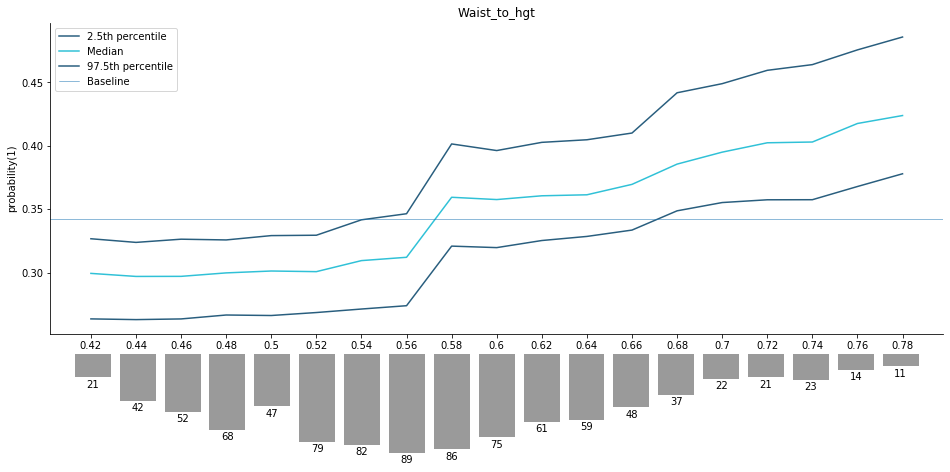

In [57]:
# visualize the results
SimulationDrawer().draw(data=waist_to_hgt_simulation, title=sim_feature)

As we can see the simulation shows that higher waist to height ratios are associated with an increased risk of prediabetes. We could also suggest that keeping a person's waist to height ratio below 0.52 will reduce the likelihood of prediabetes from around 34% to 30%.

In [58]:
# can also get a print out of simulation results
SimulationDrawer("text").draw(data=waist_to_hgt_simulation, title=sim_feature)

Waist_to_hgt

probability(1):

Baseline = 0.342

Partition  2.5th percentile  Median     97.5th percentile
=========  ================  =========  =================
0.42               0.263      0.299              0.327   
0.44               0.263      0.297              0.324   
0.46               0.263      0.297              0.326   
0.48               0.267      0.3                0.326   
0.5                0.266      0.301              0.329   
0.52               0.268      0.301              0.329   
0.54               0.271      0.309              0.342   
0.56               0.274      0.312              0.346   
0.58               0.321      0.359              0.401   
0.6                0.32       0.358              0.396   
0.62               0.325      0.361              0.403   
0.64               0.329      0.361              0.405   
0.66               0.334      0.37               0.41    
0.68               0.349      0.386              0.442   
0.7                0.35

# Summary

With the capabilities offered by FACET we were able to:

1. Identify a learner with performance comparable to models in the literature.
2. Utilize advanced the SHAP value capabilities (synergy and redundancy) to identify additional features that could be removed (i.e., BMI and waist circumference removed in favour of waist to height ratio) and whether any features had strong synergistic effects - which they did not.
3. Simulate the effect of changes in waist to height ratio on the likelihood of being prediabetic.

# What can you do next?

There are several next/alternative steps that could be taken:

1. Utilize methods to deal with class imbalance and see if it improves the model.
2. Adding more features! The NHANES data is a treasure trove of information.
3. Retain diabetic patients and convert it into a multi-class learning problem.
4. What would happen if we applied survey weights when constructing a learner?
5. Further investigation of feature engineering. One could also look at different sets of measurements such as the bio-profile and perform dimension reduction first via PCA or some other method.
6. Other learners such as SVC, LDA, Elastic-Net, CNN.
7. More sophisticated imputation for missing values: the assumption of MAR might not hold, as those with worse health and thus more at risk of prediabetes may be more likely not to disclose poor health characteristics. Methods enabled by IterativeImputer could be used or even KNNImputer. Also feature engineering could be done post imputation in the pipeline, so values such as ratios are consistent. 

# Appendix

## Data source and study cohort

**Introduction**  
Prediabetes is a treatable condition that leads to many health complications, including eventually type 2 diabetes. Prediabetes has become an epidemic worldwide and is increasing in prevalence. As a largely asymptomatic condition, screening for prediabetes can be extremely challenging. However, early intervention, especially with lifestyle changes has been shown as effective in treating prediabetes. Accurate prediction/identification of those individuals at risk of prediabetes can improve early intervention and may provide insights into those interventions that work best. The current standard of care is a CDC prediabetes risk [screening tool](https://www.cdc.gov/diabetes/prevention/pdf/Prediabetes-Risk-Test-Final.pdf). 

**Data source**  
The dataset used in this tutorial is derived from the [National Health and Nutrition Examination Survey (NHANES) 2013-14 cross-sectional survey](https://wwwn.cdc.gov/nchs/nhanes/Search/DataPage.aspx?Component=Examination&CycleBeginYear=2013). In brief, NHANES collects demographic, socioeconomic, dietary, health, medical, dental, physiological and laboratory data on a nationally representative sample of noninstitutionalized, civilian United States residents. Please note the set-up for this data loosely follows the approach in [De Silva et al](https://pubmed.ncbi.nlm.nih.gov/31889178/).

**Patient cohort**  
In the NHANES data sub-sets of those surveyed may undergo a plasma glucose (FPG) test, oral glucose tolerance
test (OGTT), or have glycated haemoglobin (HbA1c) measured. Diabetic patients were defined as those with any of the following: FPG >= 126 mg/dl, OGTT > 200 mg/dl, HbA1c > 6.4% or a Doctor diagnosed diabetes. The created dataset contains selected information for 4356 patients aged 20 years or over who were not considered diabetic or who were not pregnant or suspected to be pregnant at the time of the survey.

**Learning target: prediabetes status**  
Using any of the available FPG, OGTT and HbA1c tests we defined patients as prediabetic where any of the following was satisfied: FPG 100–125 mg/dl, OGTT 140–200 mg/dl, or HbA1c 5.7–6.4%. Among this cohort 35% were prediabetic (n=1509).

**Initial features**  
The following tables provides an overview of the 37 features included in the example dataset.

|Instrument	|Data File Name (File)	| NHANES Field	| Description | Dataset name | Type |
| :-- | :-- | :-- | :-- | :-- | :-- |
|Demographics|Demographic Variables, Sample Weights (DEMO_H)|RIDAGEYR|Age in years at screening|Age|Numeric|
|Demographics|Demographic Variables, Sample Weights (DEMO_H)|RIAGENDR|Gender|Gender| Categorical|
|Examination|Body Measures (BMX_H)|BMXWT|Weight (kg)|Weight|Numeric|
|Examination|Body Measures (BMX_H)|BMXHT|Standing Height (cm)|Standing_Height|Numeric|
|Examination|Body Measures (BMX_H)|BMXWAIST|Waist Circumference (cm)|Waist_Circumference|Numeric|
|Examination|Body Measures (BMX_H)|BMXBMI|Body Mass Index (kg/m^2)|BMI|Numeric|
|Examination|Blood Pressure (BPX_H)|BPXSY1 to 4|Systolic: Blood pres mm Hg|Average_SBP| Numeric|
|Examination|Blood Pressure (BPX_H)|BPXDI1 to 4|Diastolic: Blood pres mm Hg|Average_DBP| Numeric|
|Questionnaire|Blood Pressure & Cholesterol (BPQ_H)|BPQ020|Ever told you had high blood pressure|High_BP| Categorical|
|Questionnaire|Diet Behavior & Nutrition (DBQ_H)|DBQ700|How healthy is the diet|Healthy_diet| Categorical|
|Questionnaire|Diabetes (DIQ_H)|DIQ175A|Family history|Family_hist_diab| Categorical|
|Questionnaire|Diabetes (DIQ_H)|DIQ172|Feel could be at risk for diabetes|Feel_at_risk_diab| Categorical|
|Questionnaire|Current Health Status (HSQ_H)|HSD010|General health condition|General_health| Categorical|
|Questionnaire|Medical Conditions (MCQ_H)|MCQ080|Doctor ever said you were overweight|Told_overweight| Categorical|
|Questionnaire|Physical Activity (PAQ_H)|PAQ605|Vigorous work activity|Vigorous_work_activity| Categorical|
|Questionnaire|Physical Activity (PAQ_H)|PAQ620|Moderate work activity|Moderate_work_activity| Categorical|
|Questionnaire|Physical Activity (PAQ_H)|PAQ635|Walk or bicycle|Walk_or_bicycle| Categorical|
|Questionnaire|Physical Activity (PAQ_H)|PAQ650|Vigorous recreational activities|Vigorous_rec_activity| Categorical|
|Questionnaire|Physical Activity (PAQ_H)|PAQ665|Moderate recreational activities|Moderate_rec_activity| Categorical|
|Questionnaire|Sleep Disorders (SLQ_H)|SLD010H|How much sleep do you get (hours)?|Sleep_hours| Numeric|
|Questionnaire|Sleep Disorders (SLQ_H)|SLQ050|Ever told doctor had trouble sleeping?|Trouble_sleeping| Categorical|
|Questionnaire|Sleep Disorders (SLQ_H)|SLQ060|Ever told by doctor have sleep disorder?|Sleep_disorder| Categorical|
|Questionnaire|Weight History (WHQ_H)|WHQ070|Tried to lose weight in past year|Tried_weight_loss_past_year| Categorical|
|Laboratory|Cholesterol HDL (HDL_H)|LBDHDD|Direct HDL-Cholesterol (mg/dL)|HDL_Cholesterol| Numeric|
|Laboratory|Cholesterol Total (TCHOL_H)|LBXTC|Total Cholesterol(mg/dL)|Total_Cholesterol| Numeric|
|Laboratory|Complete Blood Count (CBC_H)|LBXWBCSI|White blood cell count (1000 cells/uL)|WBC_count| Numeric|
|Laboratory|Complete Blood Count (CBC_H)|LBXRBCSI|Red blood cell count (million cells/uL)|RBC_count| Numeric|
|Laboratory|Complete Blood Count (CBC_H)|LBXHCT|Haematocrit (%)|Haematocrit| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSTR|Triglycerides (mg/dL)|Triglycerides| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSUA|Uric acid (mg/dL)|Uric_acid| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSOSSI|Osmolality (mmol/Kg)|Osmolality| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSNASI|Sodium (mmol/L)|Sodium| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSKSI|Potassium (mmol/L)|Potassium| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSGTSI|Gamma glutamyl transferase (U/L)|Gamma_glutamyl_transferase| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSCA|Total calcium (mg/dL)|Calcium| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSATSI|Alanine aminotransferase ALT (IU/L)|Alanine_aminotransferase| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSASSI|Aspartate aminotransferase AST (IU/L)|Aspartate_aminotransferase| Numeric|

## Exploratory Data Analysis (EDA)

Let's begin by doing some brief exploratory data analysis to assess the impact features might have on the likelihood someone is prediabetic and to also determine what will need to be addressed in a preprocessing pipeline.

In [59]:
# load the prepared dataframe
prediab_eda = pd.read_csv("sphinx/source/tutorial/pre_diab_nhanes.csv")
prediab_eda.head()

,Age,Gender,Waist_Circumference,Weight,Standing_Height,BMI,Average_SBP,Average_DBP,HDL_Cholesterol,Total_Cholesterol,...,Triglycerides,Uric_acid,Osmolality,Sodium,Potassium,Gamma_glutamyl_transferase,Calcium,Alanine_aminotransferase,Aspartate_aminotransferase,Pre_diab
0,73.0,2.0,NaN,52.0,162.4,19.7,137.333333,86.666667,85.0,201.0,...,88.0,4.2,290.0,142.0,4.1,31.0,10.0,28.0,36.0,1
1,56.0,1.0,123.1,105.0,158.7,41.7,157.333333,82.000000,38.0,226.0,...,327.0,9.1,287.0,143.0,3.3,22.0,9.3,16.0,24.0,0
2,61.0,2.0,110.8,93.4,161.8,35.7,122.666667,80.666667,58.0,168.0,...,68.0,5.1,281.0,140.0,3.9,17.0,9.9,21.0,20.0,1
3,56.0,2.0,85.5,61.8,152.8,26.5,122.000000,72.666667,59.0,278.0,...,262.0,3.5,277.0,139.0,4.0,21.0,9.5,24.0,23.0,0
4,65.0,1.0,93.7,65.3,172.4,22.0,141.333333,77.333333,79.0,173.0,...,39.0,6.3,281.0,140.0,4.8,24.0,9.5,20.0,29.0,0


We might also consider some rudimentary feature engineering as well, such as the ratio of waist circumference to height or the ratio of systolic to diastolic blood pressure. Let's create these two features as well.

In [60]:
prediab_eda["SBP_to_DBP"] = prediab_eda["Average_SBP"] / prediab_eda["Average_DBP"]
prediab_eda["Waist_to_hgt"] = (
    prediab_eda["Waist_Circumference"] / prediab_eda["Standing_Height"]
)
prediab_eda.head()

,Age,Gender,Waist_Circumference,Weight,Standing_Height,BMI,Average_SBP,Average_DBP,HDL_Cholesterol,Total_Cholesterol,...,Osmolality,Sodium,Potassium,Gamma_glutamyl_transferase,Calcium,Alanine_aminotransferase,Aspartate_aminotransferase,Pre_diab,SBP_to_DBP,Waist_to_hgt
0,73.0,2.0,NaN,52.0,162.4,19.7,137.333333,86.666667,85.0,201.0,...,290.0,142.0,4.1,31.0,10.0,28.0,36.0,1,1.584615,NaN
1,56.0,1.0,123.1,105.0,158.7,41.7,157.333333,82.000000,38.0,226.0,...,287.0,143.0,3.3,22.0,9.3,16.0,24.0,0,1.918699,0.775677
2,61.0,2.0,110.8,93.4,161.8,35.7,122.666667,80.666667,58.0,168.0,...,281.0,140.0,3.9,17.0,9.9,21.0,20.0,1,1.520661,0.684796
3,56.0,2.0,85.5,61.8,152.8,26.5,122.000000,72.666667,59.0,278.0,...,277.0,139.0,4.0,21.0,9.5,24.0,23.0,0,1.678899,0.559555
4,65.0,1.0,93.7,65.3,172.4,22.0,141.333333,77.333333,79.0,173.0,...,281.0,140.0,4.8,24.0,9.5,20.0,29.0,0,1.827586,0.543503


In [61]:
# first a quick look at features overall
prediab_eda.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,4356.0,47.044536,17.188703,20.000000,33.000000,45.000000,61.000000,80.000000
Gender,4356.0,1.521350,0.499601,1.000000,1.000000,2.000000,2.000000,2.000000
Waist_Circumference,4158.0,97.167268,15.799909,55.500000,85.900000,95.500000,106.500000,177.900000
Weight,4321.0,79.939968,21.135093,32.300000,65.100000,76.900000,91.100000,222.600000
Standing_Height,4318.0,167.369701,10.158315,136.300000,160.000000,167.100000,174.500000,199.400000
BMI,4314.0,28.446639,6.793577,14.100000,23.700000,27.300000,31.800000,82.900000
Average_SBP,4229.0,121.893671,17.271841,64.666667,110.000000,118.666667,131.333333,228.000000
Average_DBP,4222.0,70.280515,11.039221,22.666667,63.333333,70.666667,77.333333,128.000000
HDL_Cholesterol,4318.0,53.723020,16.240125,10.000000,42.000000,51.000000,63.000000,173.000000
Total_Cholesterol,4318.0,190.363131,39.631288,69.000000,163.000000,188.000000,214.000000,525.000000


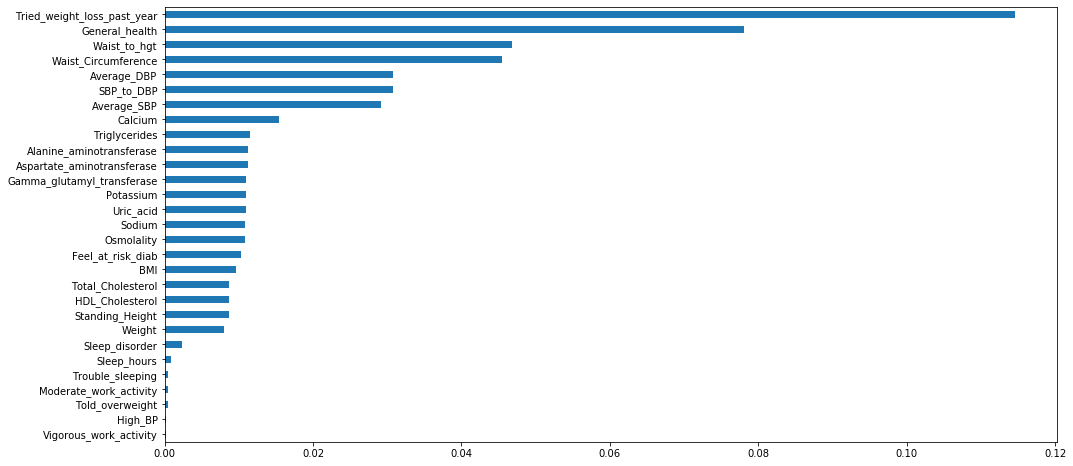

In [62]:
# missingness
miss_count = prediab_eda.isna().sum()
miss_pct = miss_count[miss_count > 0] / len(prediab_eda)
miss_pct.sort_values().plot.barh()

In [63]:
# those variables that are complete
miss_count[miss_count == 0] / len(prediab_eda)

Age                      0.0
Gender                   0.0
Family_hist_diab         0.0
Walk_or_bicycle          0.0
Vigorous_rec_activity    0.0
Moderate_rec_activity    0.0
Healthy_diet             0.0
WBC_count                0.0
RBC_count                0.0
Hematocrit               0.0
Pre_diab                 0.0
dtype: float64

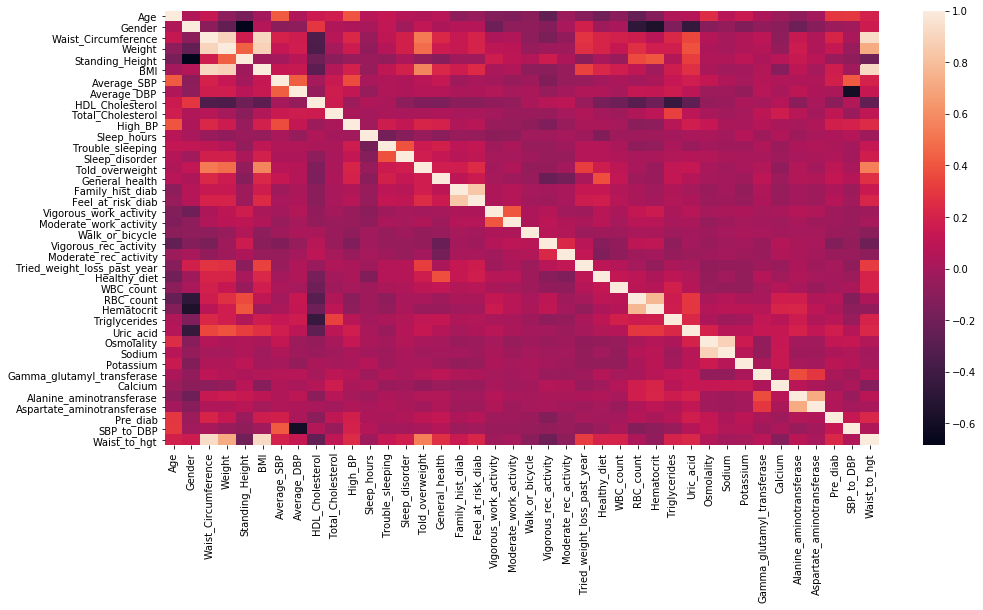

In [64]:
# view correlations with a heatmap
df_cor = prediab_eda.corr()
sns.heatmap(df_cor, xticklabels=df_cor.columns, yticklabels=df_cor.columns)

In [65]:
# let's do a table comparing features by the target
categorical = [
    "Gender",
    "High_BP",
    "Trouble_sleeping",
    "Sleep_disorder",
    "Told_overweight",
    "General_health",
    "Family_hist_diab",
    "Feel_at_risk_diab",
    "Vigorous_work_activity",
    "Moderate_work_activity",
    "Walk_or_bicycle",
    "Vigorous_rec_activity",
    "Moderate_rec_activity",
    "Tried_weight_loss_past_year",
    "Healthy_diet",
]

mytable = TableOne(
    prediab_eda,
    columns=prediab_eda.columns.drop("Pre_diab").to_list(),
    categorical=categorical,
    groupby="Pre_diab",
    pval=True,
    remarks=False,
    overall=False,
)
print(mytable)

                                          Grouped by Pre_diab                                     
                                                      Missing             0              1 P-Value
n                                                                      2847           1509        
Age, mean (SD)                                              0   43.4 (16.4)    54.0 (16.4)  <0.001
Gender, n (%)                         1.0                   0   1330 (46.7)     755 (50.0)   0.040
                                      2.0                       1517 (53.3)     754 (50.0)        
Waist_Circumference, mean (SD)                            198   94.7 (15.3)   101.9 (15.7)  <0.001
Weight, mean (SD)                                          35   77.8 (20.2)    83.9 (22.2)  <0.001
Standing_Height, mean (SD)                                 38  167.6 (10.1)   166.8 (10.2)   0.014
BMI, mean (SD)                                             42    27.6 (6.4)     30.0 (7.2)  <0.001
Average_SB

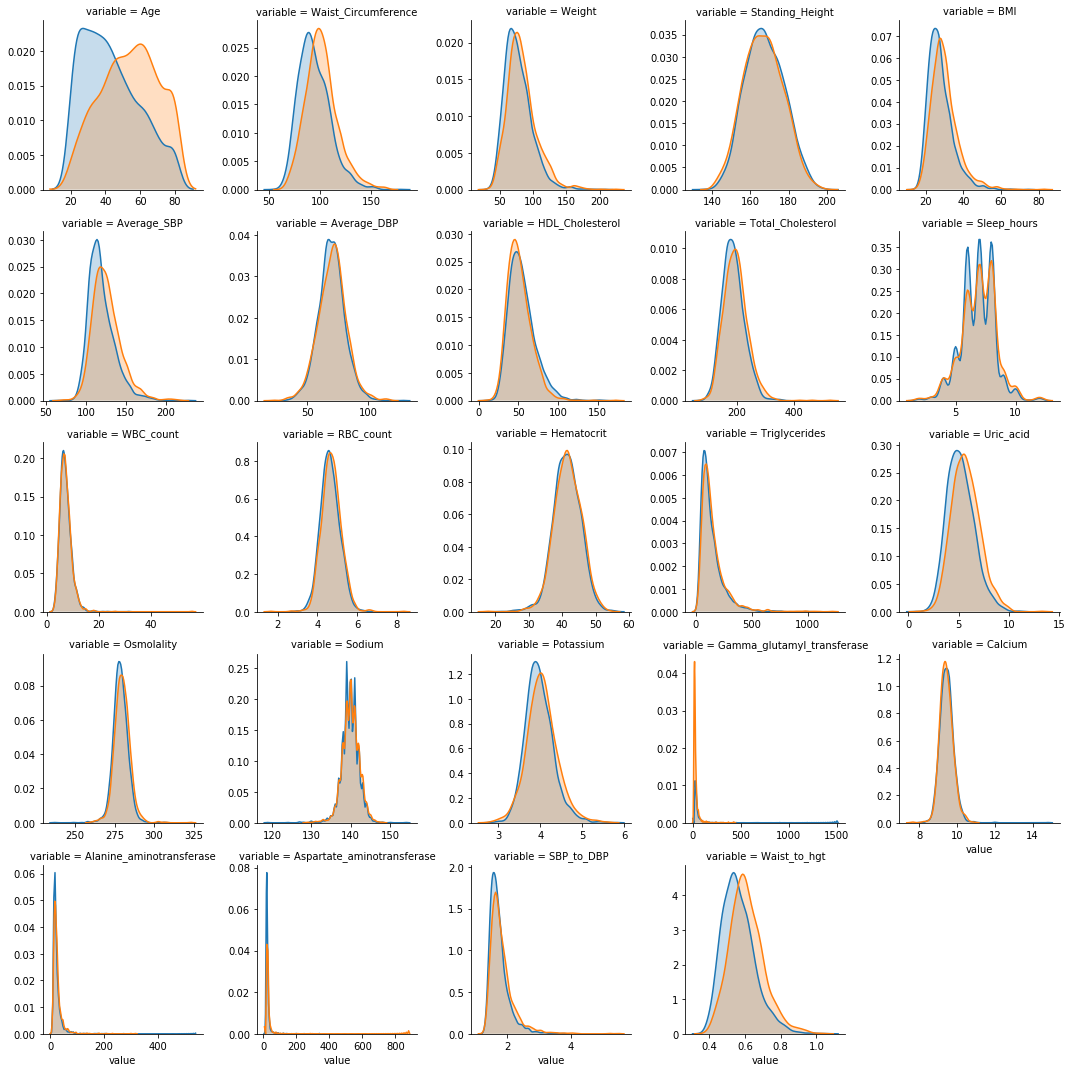

In [66]:
# KDE plots by prediabetes status as well for those continuous features
distn_vars = [
    "Age",
    "Waist_Circumference",
    "Weight",
    "Standing_Height",
    "BMI",
    "Average_SBP",
    "Average_DBP",
    "HDL_Cholesterol",
    "Total_Cholesterol",
    "Sleep_hours",
    "WBC_count",
    "RBC_count",
    "Hematocrit",
    "Triglycerides",
    "Uric_acid",
    "Osmolality",
    "Sodium",
    "Potassium",
    "Gamma_glutamyl_transferase",
    "Calcium",
    "Alanine_aminotransferase",
    "Aspartate_aminotransferase",
    "SBP_to_DBP",
    "Waist_to_hgt",
]

df_kde = pd.melt(prediab_eda[distn_vars + ["Pre_diab"]], "Pre_diab", distn_vars)
g = sns.FacetGrid(
    df_kde, col="variable", hue="Pre_diab", col_wrap=5, sharex=False, sharey=False
)
g.map(sns.kdeplot, "value", shade=True)
plt.show()

**Quick EDA summary:**

Missingness

- Our target and 10 features were complete.
- The other 29 features had levels of missing ranging from 0.02% to 11.5%, and 22 of the 29 were <3%.
- Most extreme cases of missingness were for tried weight loss in the past year (11.5%) and general health (7.8%).

Correlations

- There is a wide range of correlation among features, where we can see that for example RBC count, haematocrit and standing height are all moderately negatively correlated with gender (i.e., females are shorter), and that body measurements for weight, height, BMI, and waist circumference are all strongly positively correlated. 

Associations

- Some features already appear to not to be strongly associated based on univariate tests, such as: average DBP, trouble sleeping, vigorous work activity, moderate work activity, tried weight loss in the past year, healthy diet, WBC count, and calcium levels.
- Features associated with an increased risk of prediabetes include: older age, being male, increased waist circumference, decreased standing height, increased weight, increased BMI, increased average SBP, lower HDL cholesterol, increased total cholesterol, having high BP, increased sleep hours, having a sleep disorder, being told you are overweight, poorer general health, family history of diabetes, feeling at risk for diabetes, reduced walking or cycling, less vigorous or moderate recreational activity, higher RBC count, higher haematocrit, increased triglycerides, increased uric acid, higher osmolality, increased sodium, increased potassium, increased gamma glutamyl transferase, increased alanine aminotransferase, increased aspartate aminotransferase, increased SBP to DBP ratio, increased waist to height ratio.

Distributions of numeric features

- Many of the continuous features have been flagged as potentially non-normal/multi-modal and with potential outliers. This can be seen in the plots where many biomarkers have positive skewed distributions and in the case of sodium, some modality which could also be related to measurement.